In [1]:
%reload_ext autoreload
%autoreload 2

import numpy as np
from matplotlib import pyplot as plt
from scipy import io as sio

from utils import GenerateHaarFeatureMasks, ExtractHaarFeatures
from classifier import WeakClassifier, WeakClassifierError

plt.rcParams['figure.facecolor']='white'

In [13]:
# Hyper-parameters

# Number of randomized Haar-features
nbrHaarFeatures = 100

# Number of training images, will be evenly split between faces and
# non-faces. (Should be even.)
nbrTrainImages = 1000

# Number of weak classifiers
nbrWeakClassifiers = 50

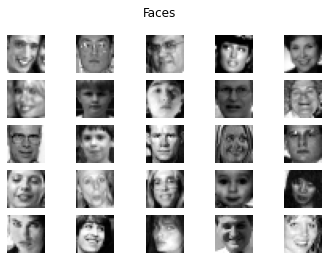

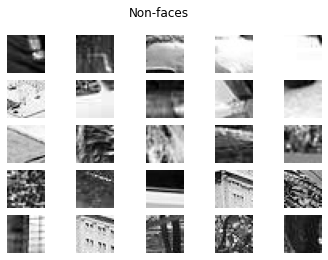

In [14]:
# Load face and non-face data and plot a few examples
faces = sio.loadmat('faces.mat')['faces']
nonfaces = sio.loadmat('nonfaces.mat')['nonfaces']

faces = faces.astype('double')[:,:,np.random.permutation(faces.shape[-1])]
nonfaces = nonfaces.astype('double')[:,:,np.random.permutation(nonfaces.shape[-1])]

plt.figure()
for i in range(25):
    plt.subplot(5,5,i+1)
    plt.imshow(faces[:,:,10*i], cmap='gray')
    plt.axis('off')
plt.suptitle('Faces')

plt.figure()
for i in range(25):
    plt.subplot(5,5,i+1)
    plt.imshow(nonfaces[:,:,10*i], cmap='gray')
    plt.axis('off')
plt.suptitle('Non-faces')
plt.show()

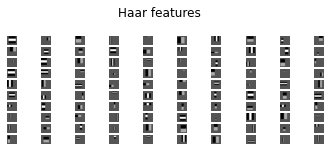

In [15]:
# Generate Haar feature masks
haarFeatureMasks = GenerateHaarFeatureMasks(nbrHaarFeatures)

plt.figure()
for k in range(nbrHaarFeatures):
    plt.subplot(20,10,k+1)
    plt.imshow(haarFeatureMasks[:,:,k], cmap='gray', vmin=-1, vmax=2)
    plt.axis('off')
plt.suptitle('Haar features')
plt.show()

In [16]:
# Create image sets (do not modify!)

# Create a training data set with examples from both classes.
# Non-faces = class label y=-1, faces = class label y=1
trainImages = np.concatenate((faces[:,:,:nbrTrainImages//2], nonfaces[:,:,:nbrTrainImages//2]), axis=2)
xTrain = ExtractHaarFeatures(trainImages,haarFeatureMasks)
yTrain = np.concatenate((np.ones(nbrTrainImages//2), -np.ones(nbrTrainImages//2)))

# Create a test data set, using the rest of the faces and non-faces.
testImages  = np.concatenate((faces[:,:,nbrTrainImages//2:], nonfaces[:,:,nbrTrainImages//2:]), axis=2)
xTest = ExtractHaarFeatures(testImages,haarFeatureMasks)
yTest = np.concatenate((np.ones(faces.shape[2]-nbrTrainImages//2), -np.ones(nonfaces.shape[2]-nbrTrainImages//2)))

# Variable for the number of test-data.
nbrTestImages = yTest.shape

In [6]:
# Implement the AdaBoost training here
# Use your implementation of WeakClassifier and WeakClassifierError in classifier.py

def StrongClassifier(nbrHaarFeatures,nbrWeakClassifiers):
    d=np.ones(nbrTrainImages)/nbrTrainImages #initial d_t(i)=1/num_XTrain
    cutoff_list=np.zeros(nbrWeakClassifiers)
    p_list=np.zeros(nbrWeakClassifiers)
    alpha_list=np.zeros(nbrWeakClassifiers)
    h_list=np.zeros(nbrWeakClassifiers)
    # to save time, we compute the values of the indicator function on training data at every possible cutoff value for all weak classifiers and saved in a 3-dimension matrix
    indicator_func=np.zeros((nbrHaarFeatures,nbrTrainImages,nbrTrainImages))
    for nhaar in range(nbrHaarFeatures):
        for t_index in range(nbrTrainImages):
            t=xTrain[nhaar,t_index]
            h=WeakClassifier(t, 1, xTrain[nhaar,])
            indicator_t=[1 if h[i]!=yTrain[i] else 0 for i in range(nbrTrainImages)]
            indicator_func[nhaar,t_index,]=indicator_t
   
    p_matrix=np.ones((nbrHaarFeatures,nbrTrainImages))      
    for niter in range(nbrWeakClassifiers): 
        error=np.array([indicator_func[i,:,:]@d for i in range(nbrHaarFeatures)])
        p_matrix[error>0.5]=-1
        error[error>0.5]=1-error[error>0.5]
        min_index=np.unravel_index(error.argmin(),error.shape,order="C") # index of parameters where error is minimized
        error_min=np.min(error) 
        p_min=p_matrix[min_index]
        h_min=WeakClassifier(xTrain[min_index],p_min,xTrain[min_index[0],])
        alpha_min=0.5*np.log((1-error_min)/error_min)
        d=np.multiply(d,np.exp(-alpha_min*np.multiply(yTrain,h_min))) # updata d
        d=d/sum(d) #renormalize d
        cutoff_list[niter]=xTrain[min_index]
        p_list[niter]=p_min
        alpha_list[niter]=alpha_min
        h_list[niter]=int(min_index[0])
    return cutoff_list, p_list, alpha_list,h_list

In [67]:
# Implement the AdaBoost training here
# Use your implementation of WeakClassifier and WeakClassifierError in classifier.py

def minerror(x_data,y_data,d):
    error_min=np.Inf
    for x in x_data:
        P=1
        h=WeakClassifier(x, P, x_data)
        error=sum(1 if h[i]!=y_data[i] else 0 for i in range(len(y_data)))/len(x_data)
        if error>0.5:
            P=-1
        h=WeakClassifier(x, P, x_data)
        error=WeakClassifierError(h, d, y_data)
        if error<error_min:
            error_min=error
            h_min=h
    return error_min,h_min

def StrongClassifier(nbrHaarFeatures,nbrWeakClassifiers):
    d_t=np.ones(nbrTrainImages)/nbrTrainImages
    alpha_list=[]
    weakclassifiers=[]
    index_list=[]
    for n_weak in range(nbrWeakClassifiers):
        error_list=np.array([minerror(xTrain[n_classifiers,],yTrain,d_t)[0] for n_classifiers in range(nbrHaarFeatures)])
        h_list=[minerror(xTrain[n_classifiers,],yTrain,d_t)[1] for n_classifiers in range(nbrHaarFeatures)]
        h_index=error_list.argmin()
        h_t=h_list[h_index]
        alpha_t=0.5*np.log((1-min(error_list))/min(error_list))
        d_t=[d_t[i]*np.exp(-alpha_t*yTrain[i]*h_t[i]) for i in range(nbrTrainImages)]
        alpha_list.append(alpha_t)
        weakclassifiers.append(h_t)
        index_list.append(h_index)
    weakclassifiers=np.array(weakclassifiers)
    strongclassifier=np.sign(sum([weakclassifiers[i,]*alpha_list[i] for i in range(nbrWeakClassifiers)]))
    return strongclassifier,alpha_list,weakclassifiers,index_list
    

In [68]:
# Evaluate your strong classifier here
# Evaluate on both the training data and test data, but only the test accuracy
# can be used as a performance metric since the training accuracy is biased.

In [69]:
strongclassifier,alpha_list,weakclassifiers,index_list=StrongClassifier(nbrHaarFeatures,nbrWeakClassifiers)
print(f"weak classifiers index:{index_list}")

C:\Users\binya518\AppData\Local\Temp\ipykernel_6984\2688252675.py:30: RuntimeWarning: invalid value encountered in double_scalars
  alpha_t=0.5*np.log((1-min(error_list))/min(error_list))


KeyboardInterrupt: 

In [9]:
alpha_list

array([7.92813632e-01, 6.35563196e-01, 5.29360036e-01, 4.80474223e-01,
       4.48763393e-01, 4.69108701e-01, 3.62340218e-01, 3.48646814e-01,
       3.13064776e-01, 6.25794399e-01, 1.25131371e+00, 2.50252618e+00,
       5.00504339e+00, 1.00100867e+01, 2.00201735e+01, 4.00403469e+01,
       8.00806938e+01, 1.60161388e+02, 3.20322775e+02,            inf,
                  nan,            nan,            nan,            nan,
                  nan,            nan,            nan,            nan,
                  nan,            nan,            nan,            nan,
                  nan,            nan,            nan,            nan,
                  nan,            nan,            nan,            nan,
                  nan,            nan,            nan,            nan,
                  nan,            nan,            nan,            nan,
                  nan,            nan])

In [10]:

def fit(cutoff,p,alpha,h_index,x):
    data=np.array([x[int(i),] for i in h_index])
    h_data=[WeakClassifier(cutoff[i],p[i],data[i,]) for i in range(len(p))]
    H_data=np.sign(sum(np.multiply(alpha.reshape(len(alpha),1),h_data)))
    return H_data

# Evaluate on the training data 
fit_train=fit(cutoff,p,alpha,h_index,xTrain)
# Evaluate on test data
fit_test=fit(cutoff,p,alpha,h_index,xTest)
# accuracy on train data
n_tr=len(yTrain)
actr=sum([1 if fit_train[i]==yTrain[i] else 0 for i in range(n_tr)])/n_tr
# accuracy on test data
n_te=len(yTest)
acte=sum([1 if fit_test[i]==yTest[i] else 0 for i in range(n_te)])/n_te
(actr,acte)

(0.0, 0.0)

In [11]:
# Plot the error of the strong classifier as a function of the number of weak classifiers.
# Note: you can find this error without re-training with a different number of weak classifiers.
# cutoff,p,alpha,h_index

def StrongClassifierError(cutoff,p,alpha,h_index,X,Y):
    fit_data=fit(cutoff,p,alpha,h_index,X)
    n_data=len(Y)
    error=sum([1 if fit_data[i]!=Y[i] else 0 for i in range(n_data)])/n_data
    return error

# calculate in training data
error_list_train=[StrongClassifierError(cutoff[0:i],p[0:i],alpha[0:i],h_index[0:i],xTrain,yTrain) for i in range(1,num_classifiers+1)]
# calculate on test data
error_list_test=[StrongClassifierError(cutoff[0:i],p[0:i],alpha[0:i],h_index[0:i],xTest,yTest) for i in range(1,num_classifiers+1)]

plt.plot(range(1,num_classifiers+1),error_list_train,color="blue",label="training data number:1000")
plt.plot(range(1,num_classifiers+1),error_list_test,color="red",label="testing data number:1000")
plt.xlabel("the number of weak classifiers")
plt.ylabel("error of the strong classifier")
plt.title(f"number of Haar-Features:{nbrHaarFeatures}")
plt.legend()
plt.show()


NameError: name 'num_classifiers' is not defined

In [ ]:
# Plot some of the misclassified faces and non-faces
# Use the subplot command to make nice figures with multiple images.
zip(fit_test,yTest)
mis_faces=testImages[:,:,[i for i in range(len(yTest)) if fit_test[i]==-1 and yTest[i]==1]]
mis_nonfaces=testImages[:,:,[i for i in range(len(yTest)) if fit_test[i]==1 and yTest[i]==-1]]

plt.figure()
for i in range(25):
    plt.subplot(5,5,i+1)
    plt.imshow(mis_faces[:,:,5*i], cmap='gray')
    plt.axis('off')
plt.suptitle('Faces')

plt.figure()
for i in range(25):
    plt.subplot(5,5,i+1)
    plt.imshow(mis_nonfaces[:,:,5*i], cmap='gray')
    plt.axis('off')
plt.suptitle('Non-faces')
plt.show()


In [ ]:
# Plot your choosen Haar-features
# Use the subplot command to make nice figures with multiple images.
index=[int(x) for x in h_index]
haar=haarFeatureMasks[:,:,index]

plt.figure()
for k in range(30):
    plt.subplot(5,6,k+1)
    plt.imshow(haar[:,:,k], cmap='gray', vmin=-1, vmax=2)
    plt.axis('off')
plt.suptitle('Haar features')
plt.show()


In [9]:
###

In [12]:
xTrain.shape

(150, 1000)

In [25]:
len(xTrain[1,:])

1000

In [19]:
a=np.ones(10)

In [20]:
a

array([1., 1., 1., 1., 1., 1., 1., 1., 1., 1.])

In [36]:
a=np.array([x+1 for x in [1,2,3,4,5]])

In [38]:
a.argmin()

0

In [40]:
a

array([2, 3, 4, 5, 6])

In [41]:
b=np.array([x+10 for x in [1,2,3,4,5]])

In [42]:
b

array([11, 12, 13, 14, 15])

In [57]:
a=np.array([])
a.append(1)
a

AttributeError: 'numpy.ndarray' object has no attribute 'append'

In [58]:
a=np.array([1,2,3])
b=np.array([[1,1,1],[2,2,2],[3,3,3]])


In [59]:
b

array([[1, 1, 1],
       [2, 2, 2],
       [3, 3, 3]])

In [60]:
b[0]*3

array([3, 3, 3])